# Setup

In [1]:
# Add parent directory to current path. Needed for research imports.
import os.path
import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.insert(0,p)

# Enable hot reloading
%load_ext autoreload
%autoreload 2


import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from experiments.irl.datasets import *
from experiments.irl.experiment_utils import *
from research.irl.fair_irl import *
from research.utils import *
from sklearn.model_selection import train_test_split


logging.basicConfig(level=logging.INFO)
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

from IPython.display import display, HTML
display(HTML("<style>.container { width:1800px !important; }</style>"))
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

# Experiment Parameters

In [45]:
base_exp_info = {
    'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'],
    # Expert demo parameters
    'DATASET': None,
    'TARGET_DATASET': None,
    'N_EXPERT_DEMOS': 3,
    'EXPERT_ALGO': None,
    'N_DATASET_SAMPLES': 50_000,
    # IRL Loop parameters
    'N_TRIALS': 1,
    'IRL_METHOD': None,
    'MIN_FREQ_FILL_PCT': .02,
    'EPSILON': .03,
    'MAX_ITER': 2,
    'METHOD': 'highs',
    'IRL_ERROR_NORM_WEIGHTS': False,
    # Plotting parameters
    'NOISE_FACTOR': .02,
    'ANNOTATE': True,

}

In [46]:
experiments = [
    {
        'DATASET': 'ACSIncome__CA',
        'TARGET_DATASET': 'ACSIncome__CA',
        'EXPERT_ALGO': 'HardtEqOpp',
        'NON_EXPERT_ALGOS': [
#             'OptAcc',
#             'HardtDemPar',
#             'HardtEqOpp',
            'Dummy',
            'Dummy',
            'Dummy',
        ],
        'IRL_METHOD': 'FairIRL',
        'N_INIT_POLICIES': 3,
    },
]

exp_info = dict(base_exp_info)
experiment = experiments[0]

for k in experiment:
    exp_info[k] = experiment[k]
    
objectives = []
for obj_name in exp_info['OBJECTIVE_NAMES']:
    objectives.append(OBJ_LOOKUP_BY_NAME[obj_name]())
obj_set = ObjectiveSet(objectives)
del objectives

# Load train/test data

In [44]:
from sklearn.model_selection import train_test_split

# Load train data (source domain)
X_source, y_source, feature_types = generate_dataset(
    'ACSIncome__AL',
    n_samples=exp_info['N_DATASET_SAMPLES'],
)

# Load test data (target domain)
X_target, y_target, _ = generate_dataset(
    'ACSIncome__CA',
    n_samples=exp_info['N_DATASET_SAMPLES'],
)

X_target_train, X_target_test, y_target_train, y_target_test = train_test_split(
    X_target, y_target, test_size=.25)
del X_target, y_target

# Train Models

### Using FairIRL
Learn weights from source train. Build classifier on target train. Predict on target test.

In [50]:
# Learn weights using source domain train set
_, _, _, weights, t_hold = run_trial_source_domain(
    exp_info,
    X=X_source,
    y=y_source,
    feature_types=feature_types,
)

# Compute optimal classifier on target domain train set
_, _, clf_pol = run_trial_target_domain(
    exp_info,
    weights,
    t_hold,
    X=X_target_train,
    y=y_target_train,
    feature_types=feature_types,
)

# Predict on target domain test set
df_test = pd.DataFrame(X_target_test)
df_test['yhat'] = clf_pol.predict(df_test).astype(int)
df_test['y'] = y_target_test
# Show the learned policy prediction rates as a gut check
display(df_test.groupby(['z'])[['yhat']].agg(['count', 'mean']))
# Show the feature expectations
feature_exp = obj_set.compute_demo_feature_exp(df_test)
feature_exp

INFO:root:muE:
[[0.73031348 0.92279375 0.96636401]
 [0.7259637  0.9208107  0.96262948]
 [0.72637264 0.97652096 0.9356211 ]]
INFO:root:muE_hold:
[[0.71715657 0.96123174 0.98809308]
 [0.73027303 0.98825003 0.97361483]
 [0.73177318 0.94109474 0.96592244]]
INFO:root:muL:
[[0.50772727 0.99849756 0.98866213]
 [0.49984848 0.99218223 0.99456283]
 [0.49424242 0.99485235 0.98663137]]
INFO:root:	IRL Loop iteration 1/2 ...
INFO:root:	IRL Loop iteration 2/2 ...
INFO:root:Best Learned Policy yhat: 0.093
INFO:root:best weight:	 [0.63  0.118 0.252]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.730,0.923,0.966,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.726,0.921,0.963,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.726,0.977,0.936,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.508,0.998,0.989,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.500,0.992,0.995,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
5,0.494,0.995,0.987,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,2.0,0.000,0.000,0.000,inf,inf,0.0,0.0
6,0.749,0.736,0.509,0,0.749,0.752,0.752,0.736,0.744,0.744,0.509,0.515,0.515,0.0,3.0,0.739,-0.090,-0.172,0.080,0.084,0.0,0.0
7,0.696,0.876,0.656,0,0.696,0.696,0.696,0.876,0.877,0.877,0.656,0.697,0.697,0.0,4.0,0.630,0.118,0.252,0.078,0.074,0.0,0.0


INFO:root:muE_target:
[[0.62848    0.95957681 0.95605353]
 [0.64544    0.97627591 0.96396617]
 [0.63936    0.97306056 0.9810085 ]]
INFO:root:target domain muL = [0.631 0.825 0.744]
INFO:root:target domain muE = [0.638 0.97  0.967]
INFO:root:target domain muL_hold = [0.622 0.837 0.779]


yhat          
  count      mean
z                
0  4747  0.450811
1  7753  0.268412

[0.62208, 0.8176011889741654, 0.7749501715207947]

### Using HardtDemPar
Train model on source train. Predict on target test.

In [51]:
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier


dem_par_thresh_opt = ThresholdOptimizer(
#     constraints='demographic_parity',
    constraints='true_positive_rate_parity',
    predict_method="predict",
    prefit=False,
    estimator=sklearn_clf_pipeline(
        feature_types=feature_types,
        # clf_inst=RandomForestClassifier(), # Messes up DemPar. Why?
        clf_inst=DecisionTreeClassifier(min_samples_leaf=10, max_depth=4),
    )
)
dem_par_wrapper = FairLearnSkLearnWrapper(
    clf=dem_par_thresh_opt,
    sensitive_features='z',
)

# Fit classifier on source train set
dem_par_wrapper.fit(X_source, y_source)

# Predict on target domain test set
df_test = pd.DataFrame(X_target_test)
df_test['yhat'] = dem_par_wrapper.predict(df_test).astype(int)
df_test['y'] = y_target_test
display(df_test.groupby(['z'])[['yhat']].agg(['count', 'mean']))
obj_set.compute_demo_feature_exp(df_test)

yhat          
  count      mean
z                
0  4747  0.283758
1  7753  0.231781

[0.65368, 0.9480230829189547, 0.9069507048716754]

### Compare against threshold optimzer trained directly on test domain

Train model on target train. Predict on target test.

In [52]:
dem_par_thresh_opt = ThresholdOptimizer(
#     constraints='demographic_parity',
    constraints='true_positive_rate_parity',
    predict_method="predict",
    prefit=False,
    estimator=sklearn_clf_pipeline(
        feature_types=feature_types,
        # clf_inst=RandomForestClassifier(), # Messes up DemPar. Why?
        clf_inst=DecisionTreeClassifier(min_samples_leaf=10, max_depth=4),
    )
)
dem_par_wrapper = FairLearnSkLearnWrapper(
    clf=dem_par_thresh_opt,
    sensitive_features='z',
)

# Fit classifier on target domain train set
dem_par_wrapper.fit(X_target_test, y_target_test)

# Predict on target domain test set
df_hold = pd.DataFrame(X_target_test)
df_hold['yhat'] = dem_par_wrapper.predict(df_hold).astype(int)
df_hold['y'] = y_target_test
display(df_hold.groupby(['z'])[['yhat']].agg(['count', 'mean']))
obj_set.compute_demo_feature_exp(df_hold)

yhat          
  count      mean
z                
0  4747  0.525174
1  7753  0.535535

[0.63488, 0.9896391622196927, 0.9979483307675924]

# Compare

In [8]:
results = [
    {
        'IRL_METHOD': 'FairIRL',
        'EXPERT_ALGO': 'OptAcc',
        'results': {
            'Accuracy': [.9, .7, .9, .8, .8],
            'DemPar':   [.8, .9, .7, .3, .5],
            'EqOpp':    [.6, .5, .7, .2, .5] ,     
        },
    },
    {
        'IRL_METHOD': 'FairIRL',
        'EXPERT_ALGO': 'HardtDemPar',
        'results': {
            'Accuracy': [.5, .3, .9, .9, .3],
            'DemPar':   [.8, .9, .6, .5, .4],
            'EqOpp':    [.3, .5, .9, .5, .5],     
        },
    },
    {
        'IRL_METHOD': 'FairIRL',
        'EXPERT_ALGO': 'HardtEqOpp',
        'results': {
            'Accuracy': [.5, .3, .9, .9, .3],
            'DemPar':   [.8, .9, .6, .5, .4],
            'EqOpp':    [.3, .5, .9, .5, .5],     
        },
    }
]

In [9]:
def compare(results):
    rows = []
    
    for metric in ['Accuracy', 'DemPar', 'EqOpp']:
        for result in results:
            metric_values = result['results'][metric]
            for metric_val in metric_values:
                row = {
                    'IRL_METHOD': result['IRL_METHOD'],
                    'EXPERT_ALGO': result['EXPERT_ALGO'],
                    'metric_name': metric,
                    'metric_value': metric_val,
                }
                rows.append(row)
                
    ordered_rows = []
    for row in rows:
        ordered_row = [
            row['IRL_METHOD'],
            row['EXPERT_ALGO'],
            row['metric_name'],
            row['metric_value'],
        ]
        ordered_rows.append(ordered_row)
        
    df = pd.DataFrame(rows, columns=['IRL_METHOD', 'EXPERT_ALGO', 'metric_name', 'metric_value'])
    
    fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
    sns.boxplot(
        x=df['metric_name'],
        y=df['metric_value'],
        hue=df['EXPERT_ALGO'],
        # hue_order=mu_hue_order,
        ax=ax1,
        fliersize=0,  # Remove outliers
        boxprops=dict(alpha=1),
        linewidth=1,
    )
    return df


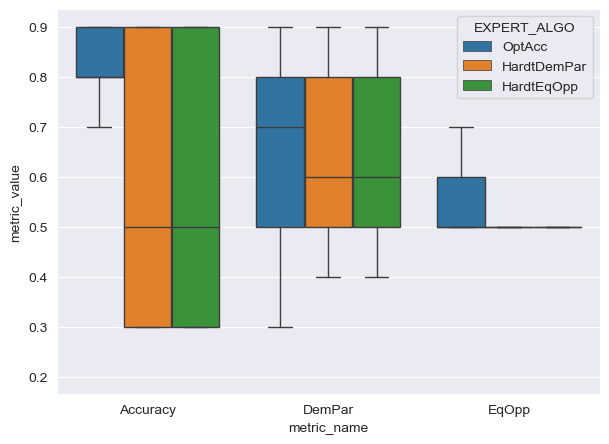

In [209]:
_df = compare(results)

In [201]:
_df

,IRL_METHOD,EXPERT_ALGO,metric_name,metric_value
0,FairIRL,HardtDemPar,Accuracy,0.5
1,FairIRL,HardtDemPar,Accuracy,0.7
2,FairIRL,HardtDemPar,Accuracy,0.9
3,FairIRL,HardtDemPar,Accuracy,0.8
4,FairIRL,HardtDemPar,Accuracy,0.3
5,FairIRL,HardtDemPar,Accuracy,0.5
6,FairIRL,HardtDemPar,Accuracy,0.3
7,FairIRL,HardtDemPar,Accuracy,0.9
8,FairIRL,HardtDemPar,Accuracy,0.9
9,FairIRL,HardtDemPar,Accuracy,0.3
